# Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
df_rwanda = pd.read_csv('./data/rwanda.csv')

X = df_rwanda['mean_light']
y = df_rwanda['wealth_index']

X = np.resize(X, (X.shape[0], 1))
y = np.resize(y, (y.shape[0], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [3]:
X_high, y_high, X_0, y_0 = [], [], [], []
for i in range(X.shape[0]):
    if X[i][0] < 5:
        X_0.append(X[i])
        y_0.append(y[i])
    else:
        X_high.append(X[i])
        y_high.append(y[i])
        
X_0 = np.resize(X_0, (len(X_0), 1))
y_0 = np.resize(y_0, (len(y_0), 1))
X_high = np.resize(X_high, (len(X_high), 1))
y_high = np.resize(y_high, (len(y_high), 1))

X_train, X_test, y_train, y_test = train_test_split(X_high, y_high, test_size=0.20, random_state=42)

# Utils

In [4]:
def plot_regression(estimator, X_train, y_train, X_test, y_test):
    x_axis = np.linspace(0, 64, 10000).reshape((10000, 1))
    y_axis = estimator.predict(x_axis)
    plt.figure(figsize=(20, 10))
    plt.grid()
    plt.xlim(-1, 64)
    plt.ylim(-2, 5)
    plt.title('Wealth prediction according to nightlight intensity')
    plt.xlabel('nightlight intensity')
    plt.ylabel('wealth')
    plt.scatter(X_train, y_train)
    plt.scatter(X_test, y_test, color='r')
    plt.plot(x_axis, y_axis)
    plt.show()

In [5]:
def plot_mse(class_estimator, alpha_min, alpha_max, precision, X_train, y_train, X_test, y_test):
    alpha_list = np.linspace(alpha_min, alpha_max, precision)
    train_MSE = []
    test_MSE = []
    for alpha in alpha_list:
        estimator = class_estimator(int(alpha))
        estimator.train(X_train, y_train)
        train_MSE.append(estimator.train_MSE)
        test_MSE.append(np.linalg.norm(y_test - estimator.predict(X_test)) / y_test.shape[0])
    plt.plot(alpha_list, test_MSE, color='red')
    plt.plot(alpha_list, train_MSE, color='green')
    plt.xlabel('hyperparameter')
    plt.ylabel('MSE')
    plt.grid()
    plt.show()

# Parametric Regression

## Linear Regression

It is assumed that $y_i = x_i^T \beta_* + \epsilon_i$ for i = 1, ... n where $\epsilon_i$ are iid random variables in $\mathbb{R}^d$, $x_i \in \mathbb{R}^d$ and $y_i \in \mathbb{R}$. $\beta_*$ is an unknown vector $\mathbb{R}^d$ we want to estimate with a least-squares estimator.  
The model is written : $$Y = X \beta _* + \epsilon$$ where $E(\epsilon) = 0$ and $E(\epsilon \epsilon^{'}) = \sigma^2_* Id$ and the matrix X has full rank.  
The least squares estimator of $\beta_*$ is defined as a solution to : $$\hat{\beta} = argmin_{\beta \in \mathbb{R}^d} || Y - X \beta || ^2 _2$$  
The analytical solution is the following estimator : $$\hat{\beta} = (X^T X)^{-1} X^T Y$$  
This estimator is unbiased and satisfies $V(\hat{\beta}) = \sigma_*^2 (X^T X)^{-1}$.

> **Proof**  
$|| Y - X \beta || ^2 _2 = (Y - X \beta)^T (Y - X \beta) = Y^TY - 2Y^TX\beta + \beta^TX^TX\beta$  
$\frac{\partial{|| Y - X \beta || ^2 _2}}{\partial{\beta}} (\beta) = - 2X^TY + 2X^TX\hat{\beta}$  
$\frac{\partial{|| Y - X \beta || ^2 _2}}{\partial{\beta}} (\hat{\beta})= 0 \implies X^TX\hat{\beta} = X^TY$ (Normal equation)  
Because X has full rank, the solution is : $$\hat{\beta} = (X^T X)^{-1} X^T Y$$  
This estimator is unbiased : $$E(\hat{\beta}) = E((X^T X)^{-1} X^T Y) = (X^T X)^{-1} X^T E(Y) = (X^T X)^{-1} X^T (E(X\beta_*) + E(\epsilon)) = (X^T X)^{-1} (X^T X) \beta_* = \beta_*$$  
and satisfies : $$V(\hat{\beta}) = V((X^T X)^{-1} X^T Y) = (X^T X)^{-1} X^T V(Y) ((X^T X)^{-1} X^T)^T = (X^T X)^{-1} X^T V(Y) X (X^TX)^{-1} = \sigma_*^2 (X^T X)^{-1} (X^T X) (X^T X)^{-1} = \sigma_*^2 (X^T X)^{-1}$$

**Probabilistic interpretation :**  
When $\epsilon_i \sim N(0, \sigma^2)$, the least squares estimator can be derived from the maximum likelihood estimator. Indeed, it implies that $(y_i|x_i; \beta) \sim N(x_i^T \beta, \sigma ^2)$.  
The likelihood is defined as $L(\beta) = P(Y|X; \beta) = \prod_{i = 1}^n P(y_i|x_i; \beta) = \prod_{i = 1}^n \frac {1}{\sqrt{2\pi} \sigma} \exp(-\frac{(y_i - x_i^T \beta)^2}{2\sigma^2})$.  
Instead of maximizing the likelihood, we can instead maximize any strictly increasing function of $L(\beta)$, such as the log-likelihood : $$l(\beta) = \log(L(\beta)) = \sum_{i=1}^n \frac {1}{\sqrt{2\pi} \sigma} \exp(-\frac{(y_i - x_i^T \beta)^2}{2\sigma^2}) = -n\log(\sqrt{2\pi} \sigma) - \frac{1}{2\sigma^2} \sum_{i=1}^n (y_i - x_i^T \beta)^2$$  
Thus, maximizing $l(\beta)$ is equivalent to minimizing $$||Y - X\beta||^2_2 = \sum_{i=1}^n (y_i - x_i^T \beta)^2$$

**LMS (Least Mean Squares) Algorithm :**  
We can then consider this problem as the minimization of the following cost function : $$J(\beta) = ||Y - X\beta||^2_2$$  
To obtain the minimum, let's consider the gradient descent algorithm : $$\beta_{t+1} = \beta_t - \alpha \frac{\partial{J}}{\partial\beta}(\beta_t)$$  
This gives the update rule : $$\beta_{t+1} = \beta_t - \alpha ...$$  

> **Proof**
$\frac{\partial{J}}{\partial\beta}(\beta_t) = ...$

In [51]:
class LinearRegression:
    
    def __init__(self):
        self.coeff = None
        self.train_MSE = None
        
    def fit(self, X_train, y_train):
        intercept = np.ones((X_train.shape[0], 1))
        X = np.append(intercept, X_train, axis=1)
        
        beta = np.linalg.pinv(np.dot(X.T, X)).dot(np.dot(X.T, y_train))
        
        #beta = np.linalg.inv(np.dot(X.T, X)).dot(np.dot(X.T, y_train))
        #beta = scipy.linalg.solve(np.dot(X.T, X), np.dot(X.T, y_train))
        #beta, _, _, _ = np.linalg.lstsq(np.dot(X.T, X), np.dot(X.T, y_train))
        
        self.coeff = beta
        self.train_MSE = np.sqrt(np.linalg.norm(y_train - self.predict(X_train)) ** 2 / y_train.shape[0])
    
    def predict(self, X_test):
        intercept = np.ones((X_test.shape[0], 1))
        X = np.append(intercept, X_test, axis=1)
        
        y_test = np.dot(X, self.coeff)
        
        return y_test

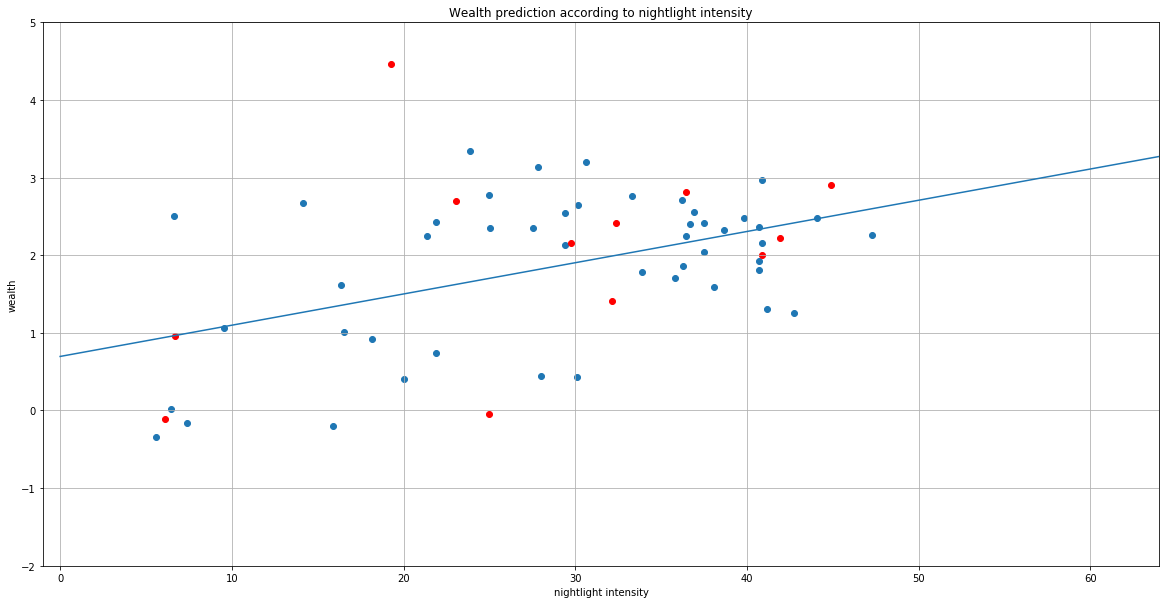

MSE on train data : 0.8332488619962429
MSE on test data : 1.1390616983551884


In [52]:
estimator = LinearRegression()
estimator.fit(X_train, y_train)

plot_regression(estimator, X_train, y_train, X_test, y_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.sqrt(np.linalg.norm(y_test - estimator.predict(X_test)) ** 2 / y_test.shape[0]))

## Ridge Regression

Model : $$Y = X \beta_* + \epsilon$$  
Regularized least squares estimator : $$\beta_n = argmin_{\beta \in \mathbb{R}^d} || Y - X \beta || ^2 _2 + \gamma || \beta || ^2 _2$$
Analytical solution : $$\beta_n = (X^T X + \gamma Id)^{-1} X^T Y$$  

- an example of regularized linear regression
- $(X^TX + \gamma I_n)$ is always nonsingular
- common approach to control estimator variance
- can be derive from MAP estimator
- but the estimator is now biased
- there exists another way to write the analytical solution

In [54]:
class RidgeRegression:
    
    def __init__(self, gamma=None):
        self.gamma = gamma
        self.coeff = None
        self.train_MSE = None
        
    def fit(self, X_train, y_train):        
        intercept = np.ones((X_train.shape[0], 1))
        X = np.append(intercept, X_train, axis=1)
        
        beta = np.dot(np.linalg.pinv(np.dot(X.T, X) + self.gamma * np.identity(X.shape[1])), np.dot(X.T, y_train))
        #beta = np.dot(X.T, np.linalg.pinv(np.dot(X, X.T) + self.gamma * np.identity(X.shape[0])).dot(y_train))
        
        self.coeff = beta
        self.train_MSE = np.sqrt(np.linalg.norm(y_train - self.predict(X_train)) ** 2 / y_train.shape[0])
    
    def predict(self, X_test):
        intercept = np.ones((X_test.shape[0], 1))
        X = np.append(intercept, X_test, axis=1)
        
        y_test = np.dot(X, self.coeff)
        
        return y_test

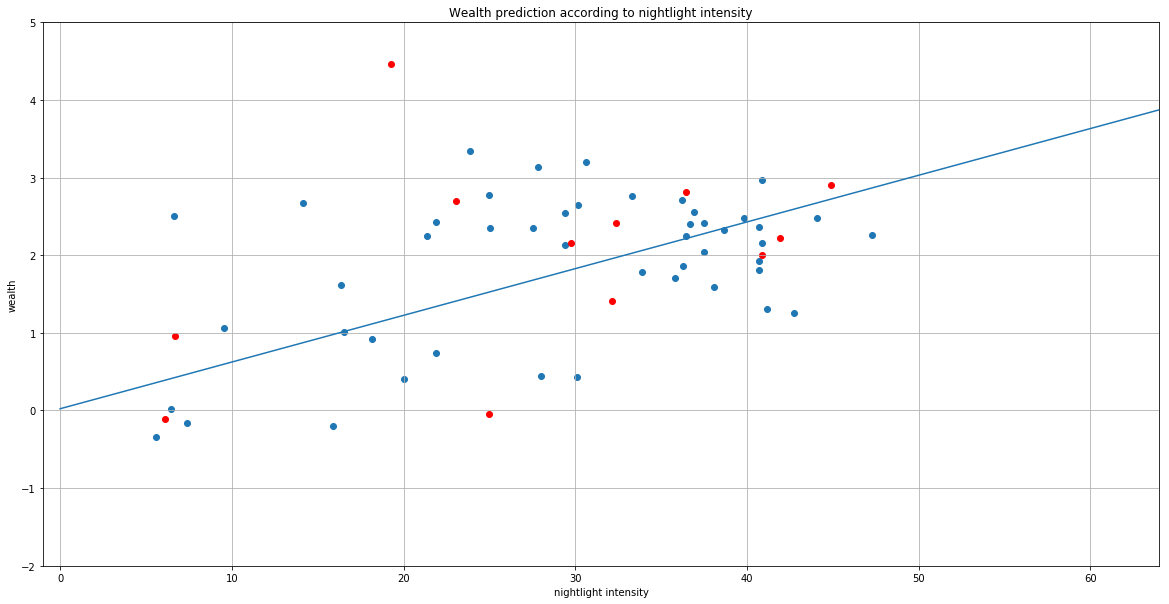

MSE on train data : 0.8680144176470768
MSE on test data : 1.182285083692929


In [57]:
estimator = RidgeRegression(gamma=200)
estimator.fit(X_train, y_train)

plot_regression(estimator, X_train, y_train, X_test, y_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.sqrt(np.linalg.norm(y_test - estimator.predict(X_test)) ** 2 / y_test.shape[0]))

#plot_mse(RidgeRegression, 0, 200, 100, X_train, y_train, X_test, y_test)

## Lasso Regression

Model : $$Y = X \beta_* + \epsilon$$  
Regularized least squares estimator : $$\beta_n = argmin || Y - X \beta || ^2 _2 + \gamma || \beta || _1$$  

- convex but not differentiable
- we can explicit the solution or use gradient descent or LP (interior-points method)

In [70]:
from sklearn.linear_model import Lasso

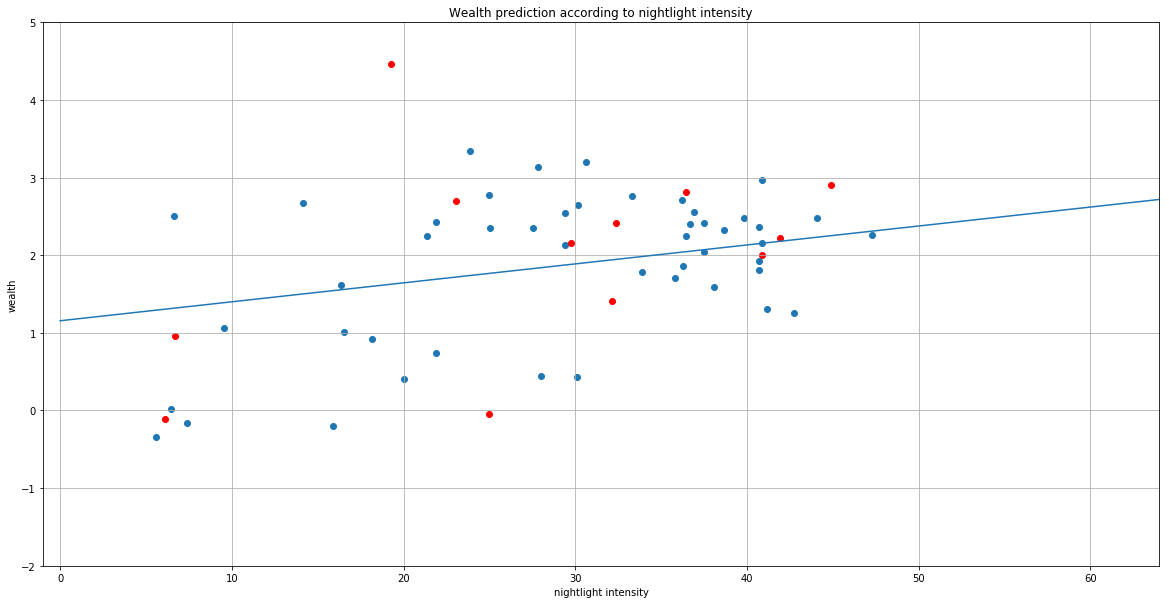

MSE on train data : 6.765924009229165
MSE on test data : 4.436226970075457


In [67]:
estimator = Lasso(2.)
estimator.fit(X_train, y_train)

plot_regression(estimator, X_train, y_train, X_test, y_test)

print('MSE on train data :', np.sqrt(np.linalg.norm(y_train - estimator.predict(X_train)) ** 2 / y_train.shape[0]))
print('MSE on test data :', np.sqrt(np.linalg.norm(y_test - estimator.predict(X_test)) ** 2 / y_test.shape[0]))

## Bayesian Ridge Regression

- bayesian approach
- prior probability distribution on the weights
- posterior probability distribution from the data thanks to MAP estimator
- confidence interval on the weights

In [71]:
from sklearn.linear_model import BayesianRidge

/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


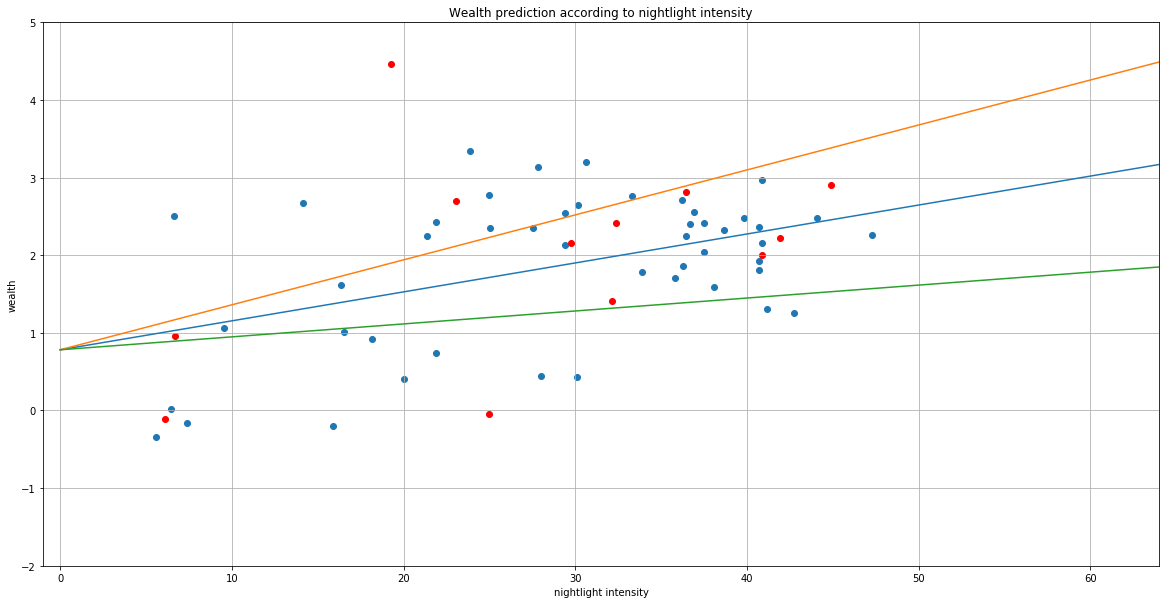

MSE on train data : 7.105967131430625
MSE on test data : 4.598593503473573


In [91]:
estimator = BayesianRidge()
estimator.fit(X_train, y_train)

x_axis = np.linspace(0, 64, 10000).reshape((10000, 1))
y_axis = estimator.predict(x_axis)
y_axis_max = np.dot(x_axis, estimator.coef_ + 1.96 * np.sqrt(estimator.sigma_)) + estimator.intercept_
y_axis_min = np.dot(x_axis, estimator.coef_ - 1.96 * np.sqrt(estimator.sigma_)) + estimator.intercept_
plt.figure(figsize=(20, 10))
plt.grid()
plt.xlim(-1, 64)
plt.ylim(-2, 5)
plt.title('Wealth prediction according to nightlight intensity')
plt.xlabel('nightlight intensity')
plt.ylabel('wealth')
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test, color='r')
plt.plot(x_axis, y_axis)
plt.plot(x_axis, y_axis_max)
plt.plot(x_axis, y_axis_min)
plt.show()


print('MSE on train data :', np.sqrt(np.linalg.norm(y_train - estimator.predict(X_train)) ** 2 / y_train.shape[0]))
print('MSE on test data :', np.sqrt(np.linalg.norm(y_test - estimator.predict(X_test)) ** 2 / y_test.shape[0]))

# Nonparametric Regression

Nonparametric regression is a natural extension of parametric regression. There are several approaches. Firstly, we can predict a value by looking at the known values in its neighboring (kNN, smoothing, local regression). Secondly, we can extend the least-squares estimator by minimizing it on a functional space (polynomial, RKHS).

## Smoothing, local linear regression

Model : $$\hat{y} = \sum_{i=1}^n \frac {w_i(x)}{\sum_{j=1}^n w_j(x)} y_i$$

### k-Nearest-Neighbors Regression

k-NN regression is based on a rough weighting : it takes into account only the k nearest points to the tested point and returns a mean of them.  
$$x_i \in N_k(x) \implies w_i(x) = 1$$
$$x_i \notin N_k(x) \implies w_i(x) = 0$$
where $N_k(x)$ is the set of the k nearest points to x.  
Thus : $$\hat{y} = \frac{1}{k} \sum_{x_i \in N_k(x)} y_i$$

In [92]:
class NearestNeighborsRegression:
    
    def __init__(self, k):
        self.k = int(k)
        self.X = None
        self.y = None
        self.train_MSE = None
    
    def distance(self, x, y):
        return np.linalg.norm(x - y)
        
    def fit(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
        self.train_MSE = np.sqrt(np.linalg.norm(y_train - self.predict(X_train)) ** 2 / y_train.shape[0])
    
    def predict(self, X_test):
        y_test = []
        for x_test in X_test:
            distance_matrix = [self.distance(x_test, self.X[i]) for i in range(self.X.shape[0])]
            idx = np.argsort(distance_matrix)[:self.k]
            res = np.mean(y_train[idx])
            y_test.append(res)
        y_test = np.array(y_test)
        return y_test

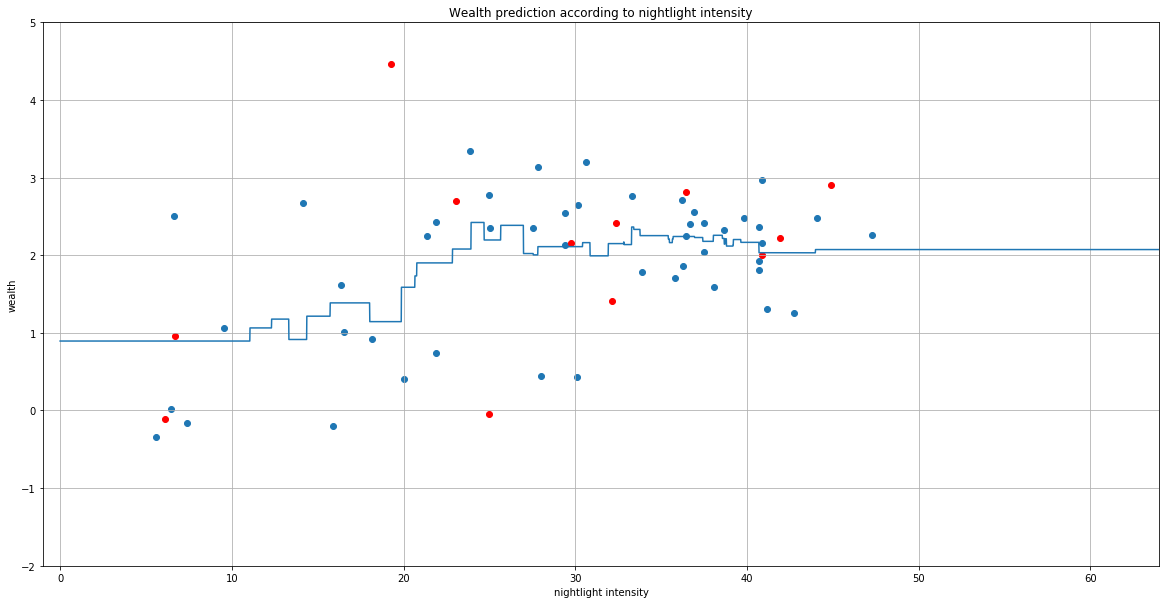

MSE on train data : 7.222107040516171
MSE on test data : 4.653861942061155


In [93]:
estimator = NearestNeighborsRegression(k=8)
estimator.fit(X_train, y_train)

plot_regression(estimator, X_train, y_train, X_test, y_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.sqrt(np.linalg.norm(y_test - estimator.predict(X_test)) ** 2 / y_test.shape[0]))

#plot_mse(NearestNeighborsRegression, 1, 10, 10, X_train, y_train, X_test, y_test)

### Kernel Smoothing

This is a smoother approach than precedently. Weights are, again, calculated based on the distance to the test point but all training points are took into account for the prediction. Weights decrease to zero with the distance, this decreasing is determined by the chosen kernel.  
$$w_i(x) = k(x_i, x)$$

In [96]:
class KernelSmoothing:
    
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
        self.X = None
        self.y = None
        self.train_MSE = None
        
    def kernel(self, x, y):
        return (1 / np.sqrt(2*np.pi)) * np.exp(- 0.5 * np.linalg.norm(x - y)**2 / self.bandwidth**2)
    
    def fit(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
        self.train_MSE = np.sqrt(np.linalg.norm(y_train - self.predict(X_train)) ** 2 / y_train.shape[0])
        
    def predict(self, X_test):
        y_test = []
        for x_test in X_test:
            W = [self.kernel(x_test, self.X[i]) for i in range(self.X.shape[0])]
            res = np.dot(W, self.y) / np.sum(W)
            y_test.append(res)
        y_test = np.array(y_test)
        return y_test

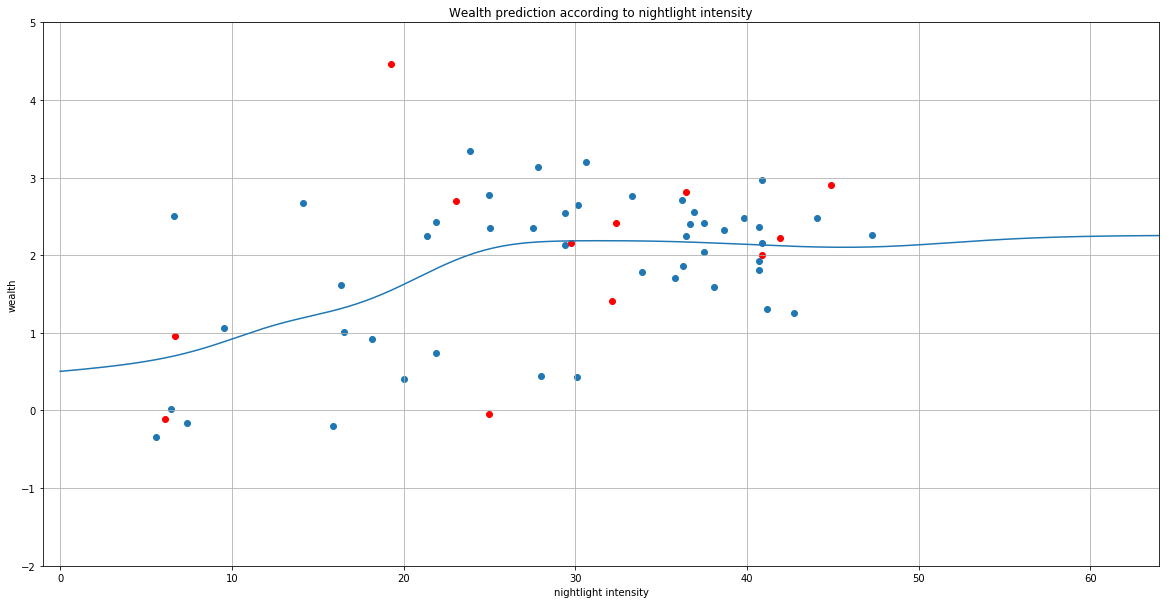

MSE on train data : 0.7821075854348237
MSE on test data : 1.1545221840377042


In [97]:
estimator = KernelSmoothing(4.35)
estimator.fit(X_train, y_train)

plot_regression(estimator, X_train, y_train, X_test, y_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.sqrt(np.linalg.norm(y_test - estimator.predict(X_test)) ** 2 / y_test.shape[0]))

#plot_mse(KernelSmoothing, 0, 10, 10, X_train, y_train, X_test, y_test)

### Local Linear Regression

We can show that the precedent model is equivalent to the following procedure :  
1. Fit $\beta$ to minimize $\sum_{i=1}^n w_i(x) (y_i - \beta)^2$  
2. Output $\beta$  

Instead, we could consider forming a local linear estimator : that's local linear regression.  
1. Fit $\beta$ to minimize $\sum_{i=1}^n w_i(x) (y_i - x^T \beta)^2$  
2. Output $x^T \beta$  

The minimization problem is written, in matrix form : $$\hat{\beta} = (Y - X\beta)^T W(x_0) (Y - X\beta)$$  
This is very similar to the least squares problem, the solution is then : $$\hat{\beta} = (X^T W(x_0) X)^{-1}X^T W(x_0) ^TY$$ and $$y = x_0^T (X^T W(x_0) X)^{-1}X^T W(x_0) ^TY$$

Instead of doing the weighted sum of neighbor's values to estimate a new one (kernel smoothing), we fit a linear regression locally arround the value we want to predict. To fit this linear regression, we consider the surrounding points with a weights which depends on their distance from the point. The only advantage over kernel smoothing is to have a more reliable prediction on the edge of the domain.

In [98]:
class LocallyWeightedLinearRegression:
    
    def __init__(self, bandwidth):
        self.bandwidth = bandwidth
        self.X = None
        self.y = None
        self.train_MSE = None
    
    def kernel(self, x, y):
        return np.exp(- 0.5 * np.linalg.norm(x - y)**2 / self.bandwidth**2)
        
    def fit(self, X_train, y_train):
        intercept = np.ones((X_train.shape[0], 1))
        self.X = np.append(intercept, X_train, axis=1)
        self.y = y_train
        self.train_MSE = np.sqrt(np.linalg.norm(y_train - self.predict(X_train)) ** 2 / y_train.shape[0])
    
    def predict(self, X_test):
        Y_test = []
        for x_test in X_test:
            x_test = np.resize(x_test, (1, 1))
            W = [self.kernel(x_test, self.X[i]) for i in range(self.X.shape[0])]
            W = np.diag(W)
            beta = scipy.linalg.solve(np.dot(self.X.T, W).dot(self.X), np.dot(self.X.T, W).dot(self.y))
            intercept = np.ones((x_test.shape[0], 1))
            x_test = np.append(intercept, x_test, axis=1)
            y_test = np.dot(x_test, beta)
            Y_test.append(y_test)
        Y_test = np.array(Y_test)
        Y_test = np.resize(Y_test, (Y_test.shape[0], 1))
        return Y_test

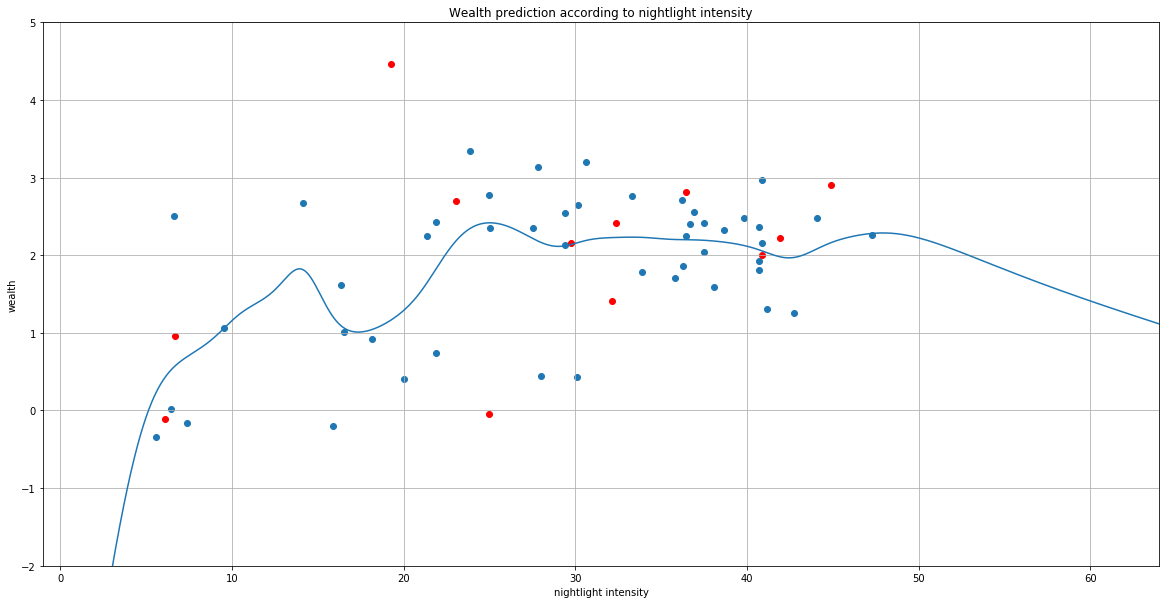

MSE on train data : 0.719418917243453
MSE on test data : 1.2680733942614102


In [99]:
estimator = LocallyWeightedLinearRegression(bandwidth=2.)
estimator.fit(X_train, y_train)

plot_regression(estimator, X_train, y_train, X_test, y_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.sqrt(np.linalg.norm(y_test - estimator.predict(X_test)) ** 2 / y_test.shape[0]))

#plot_mse(LocallyWeightedLinearRegression, 2, 10, 10, X_train, y_train, X_test, y_test)

### Local Polynomial Regression

In [19]:
class LocallyWeightedPolynomialRegression:
    
    def __init__(self, bandwidth, p):
        self.bandwidth = bandwidth
        self.p = p
        self.X = None
        self.y = None
        self.train_MSE = None
    
    def kernel(self, x, y):
        return np.exp(- 0.5 * np.linalg.norm(x - y)**2 / self.bandwidth**2)
    
    def phi(self, x, j):
        return x**j
        
    def fit(self, X_train, y_train):
        n = X_train.shape[0]
        self.X = [[self.phi(X_train[i], j) for j in range(self.p)] for i in range(n)]
        self.X = np.resize(self.X, (np.shape(self.X)[0], np.shape(self.X)[1]))
        self.y = y_train
        self.train_MSE = np.sqrt(np.linalg.norm(y_train - self.predict(X_train)) ** 2 / y_train.shape[0])
    
    def predict(self, X_test):
        m = X_test.shape[0]
        psi_test = [[self.phi(X_test[i], j) for j in range(self.p)] for i in range(m)]
        psi_test = np.resize(psi_test, (np.shape(psi_test)[0], np.shape(psi_test)[1]))
        Y_test = []
        for x_test in psi_test:
            x_test = np.resize(x_test, (1, x_test.shape[0]))
            W = [self.kernel(x_test, self.X[i]) for i in range(self.X.shape[0])]
            W = np.diag(W)
            beta = scipy.linalg.solve(np.dot(self.X.T, W).dot(self.X), np.dot(self.X.T, W).dot(self.y))
            #intercept = np.ones((x_test.shape[0], 1))
            #x_test = np.append(intercept, x_test, axis=1)
            y_test = np.dot(x_test, beta)
            Y_test.append(y_test)
        Y_test = np.array(Y_test)
        Y_test = np.resize(Y_test, (Y_test.shape[0], 1))
        return Y_test

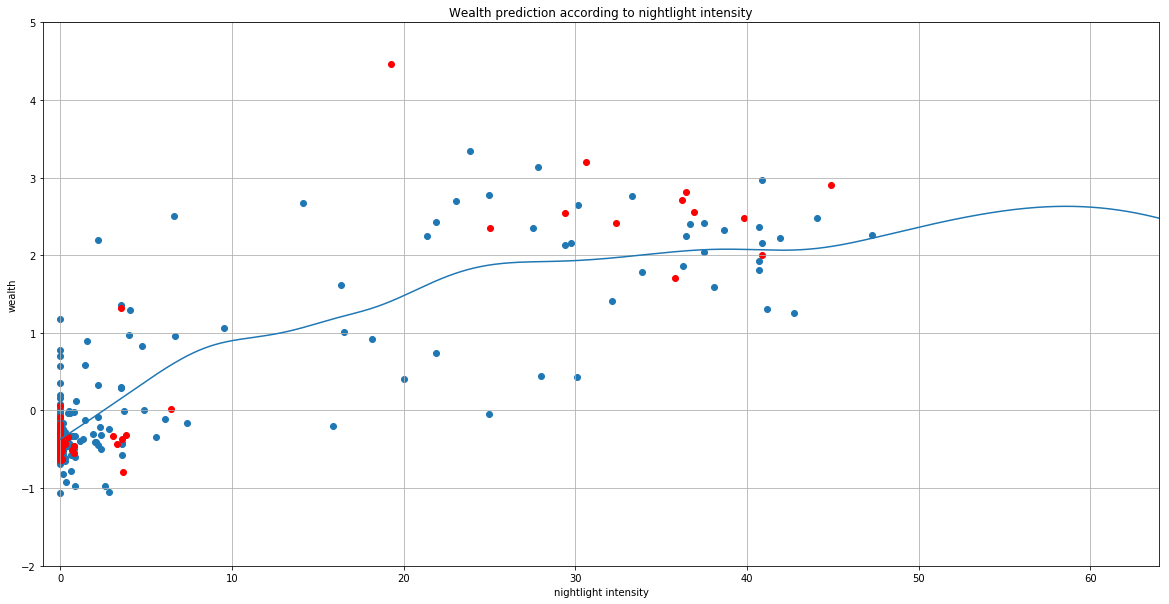

MSE on train data : 0.39539026458187415
MSE on test data : 0.44224395927112436


In [20]:
estimator = LocallyWeightedPolynomialRegression(bandwidth=4., p=2)
estimator.fit(X_train, y_train)

plot_regression(estimator, X_train, y_train, X_test, y_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.sqrt(np.linalg.norm(y_test - estimator.predict(X_test)) ** 2 / y_test.shape[0]))

#plot_mse(LocallyWeightedPolynomialRegression, 2, 10, 10, X_train, y_train, X_test, y_test)

## Projection on a functional basis, kernel regression

### Polynomial basis

In [21]:
class PolynomialRegression:
    
    def __init__(self, p):
        self.coeff = None
        # p = maximum polynomial degree
        self.p = int(p + 1)
        self.train_MSE = None
    
    def phi(self, x, j):
        return x**j
        
    def fit(self, X_train, y_train):
        n = X_train.shape[0]
        psi = [[self.phi(X_train[i], j) for j in range(self.p)] for i in range(n)]
        psi = np.resize(psi, (np.shape(psi)[0], np.shape(psi)[1]))
        
        alpha = scipy.linalg.solve(np.dot(psi.T, psi), np.dot(psi.T, y_train))
        self.coeff = alpha
        
        #print("MSE =", np.linalg.norm(y_train - np.dot(psi, self.coeff)))
        self.train_MSE = np.sqrt(np.linalg.norm(y_train - self.predict(X_train)) ** 2 / y_train.shape[0])
    
    def predict(self, X_test):
        m = X_test.shape[0]
        psi_test = [[self.phi(X_test[i], j) for j in range(self.p)] for i in range(m)]
        psi_test = np.resize(psi_test, (np.shape(psi_test)[0], np.shape(psi_test)[1]))
        y_test = np.dot(psi_test, self.coeff)
        return y_test

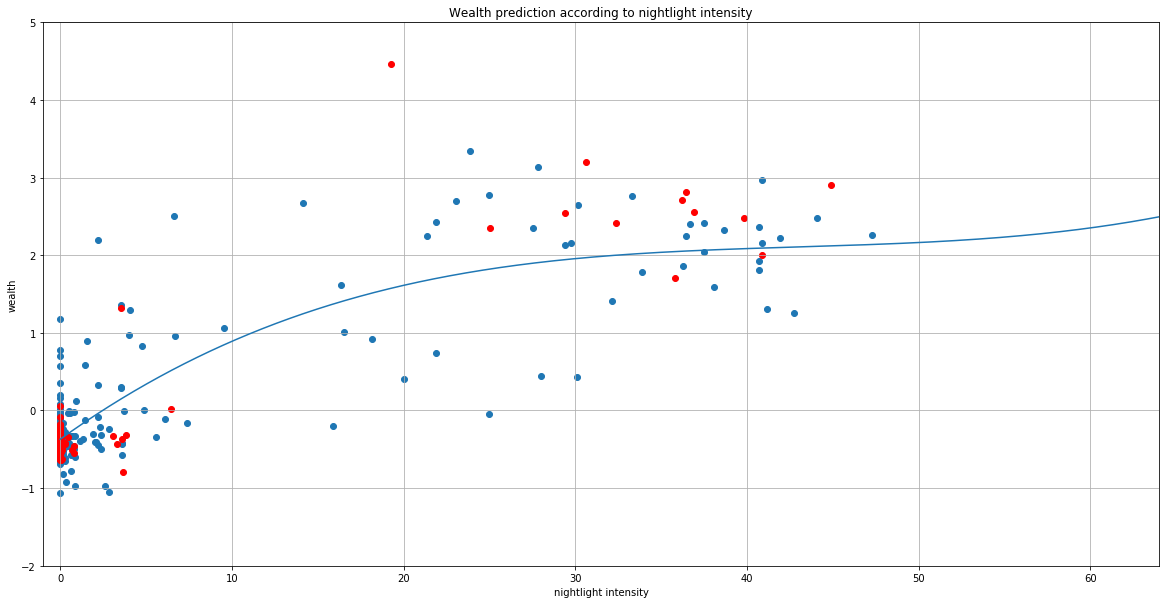

MSE on train data : 0.39791843192397164
MSE on test data : 0.42898043760370863


/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/ipykernel_launcher.py:17: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.343449e-20
/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/ipykernel_launcher.py:17: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.700093e-23
/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/ipykernel_launcher.py:17: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.092146e-27
/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/ipykernel_launcher.py:17: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.240151e-34


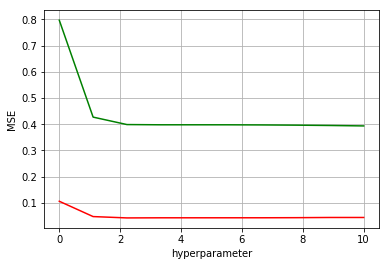

In [22]:
estimator = PolynomialRegression(p=3)
estimator.fit(X_train, y_train)

plot_regression(estimator, X_train, y_train, X_test, y_test)

print('MSE on train data :', estimator.train_MSE)
print('MSE on test data :', np.sqrt(np.linalg.norm(y_test - estimator.predict(X_test)) ** 2 / y_test.shape[0]))

#plot_mse(PolynomialRegression, 0, 10, 10, X_train, y_train, X_test, y_test)

## SVR

In [101]:
from sklearn.svm import SVR

/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ridouane/anaconda3/envs/Predict-poverty/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


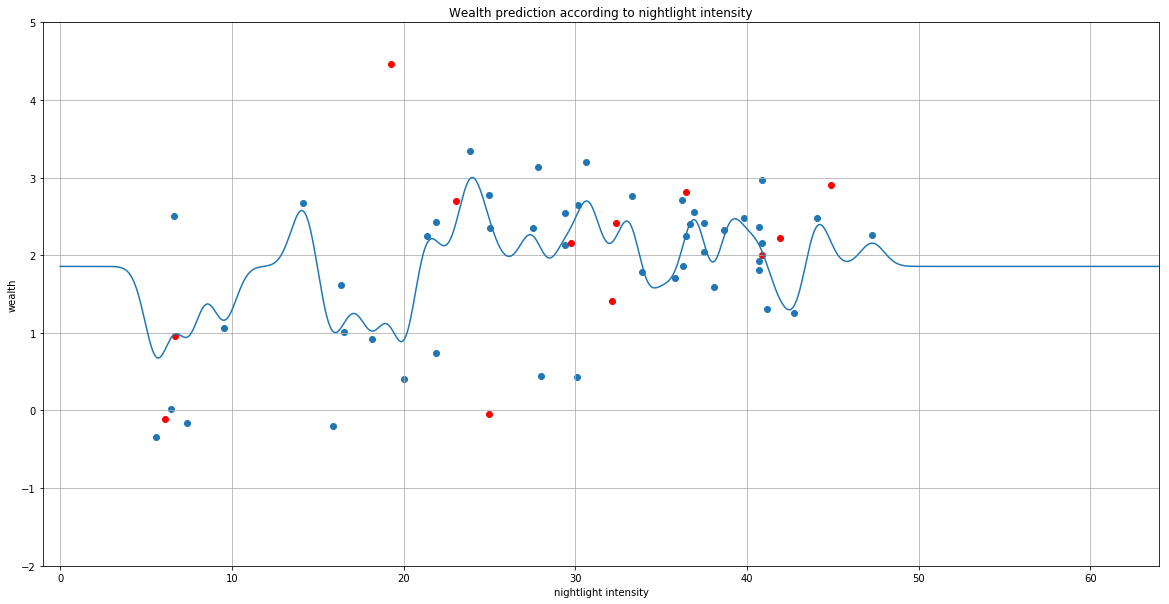

MSE on train data : 7.593588870159064
MSE on test data : 4.776637164434454


In [102]:
estimator = SVR()
estimator.fit(X_train, y_train)

plot_regression(estimator, X_train, y_train, X_test, y_test)

print('MSE on train data :', np.sqrt(np.linalg.norm(y_train - estimator.predict(X_train)) ** 2 / y_train.shape[0]))
print('MSE on test data :', np.sqrt(np.linalg.norm(y_test - estimator.predict(X_test)) ** 2 / y_test.shape[0]))

# Bibliographie

Nonparametric Regression theory : http://www.stat.cmu.edu/~larry/=sml/nonpar.pdf  